### Perceptron

In [1]:
import torch
import torch.nn as nn

class Perceptron(nn.Module):
    """ A perceptron is one linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
       
    def forward(self, x_in):
        """The forward pass of the perceptron
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, num_features)
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        return torch.sigmoid(self.fc1(x_in)).squeeze()


### Activation Function

/Users/ling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  after removing the cwd from sys.path.


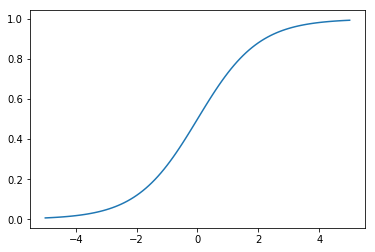

In [3]:
import torch
import matplotlib.pyplot as plt

x = torch.range(-5., 5., 0.1)
y = torch.sigmoid(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

/Users/ling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.


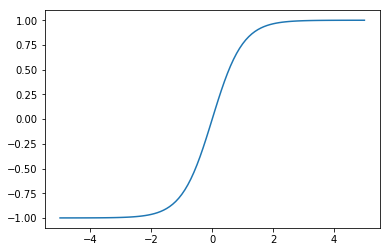

In [4]:
x = torch.range(-5., 5., 0.1)
y = torch.tanh(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

/Users/ling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


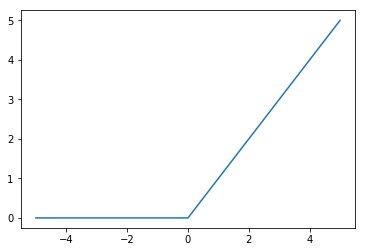

In [7]:
relu = torch.nn.ReLU()
x = torch.range(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

/Users/ling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


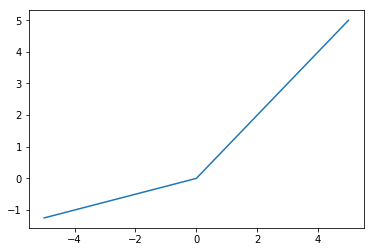

In [8]:
prelu = torch.nn.PReLU(num_parameters=1)
x = torch.range(-5., 5., 0.1)
y = prelu(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

In [9]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[ 2.0159, -0.5455,  0.5698]])
tensor([[0.7618, 0.0588, 0.1794]])
tensor([1.])


In [10]:
mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(2.2866, grad_fn=<MseLossBackward>)


In [11]:
ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
print(loss)

tensor(2.1983, grad_fn=<NllLossBackward>)


In [12]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0],  dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss)

tensor([[0.5265],
        [0.2505],
        [0.1046],
        [0.5997]], grad_fn=<SigmoidBackward>)
tensor(1.0257, grad_fn=<BinaryCrossEntropyBackward>)


In [14]:
import torch.optim as optim
input_dim = 2
lr = 0.001

perceptron = Perceptron(input_dim=input_dim)
bce_loss = nn.BCELoss()
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)

### Classifying Sentiment of Restaurant Reviews

In [17]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        return cls(review_df, ReviewVectorizer.from_dataframe(review_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

In [18]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [19]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

In [20]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class ReviewClassifier(nn.Module):
    """ a simple perceptron-based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = F.sigmoid(y_out)
        return y_out

In [16]:
import collections
# Split the subset by rating to create new train, val, and test splits
by_rating = collections.defaultdict(list)
for _, row in review_subset.iterrows():
    by_rating[row.rating].append(row.to_dict())

NameError: name 'review_subset' is not defined